### Survival Analysis

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython
%reload_ext Cython

In [2]:
#built-in
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import sys
import matplotlib.pyplot as plt

path = str(Path.home()) + '/rpi-canary-eval/temp'
git_path = str(Path.home()) + '/rpi-canary-eval'
sys.path.append(git_path + '/modules')


#custom
import data_process
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from path import path_dict, col_seq_cc, col_seq_elx, col_seq_cc_all

#options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

from lifelines import KaplanMeierFitter
from diabetes_onset import survival_diabetes

/home/nneehal/.local/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# keys = ["treated0_o.p", "treated1_o.p", "random_o.p", "match0_o.p", "match1_o.p"]
# s3 = boto3.client('s3')
# bucket = 'cdphp-s3-us-e-p-pond'
# aws_path = "rpi/nneehal/DATA/odata/metabolic/"
# local_path = str(Path.home()) + '/rpi-canary-eval/temp/odata/'
# for key in keys:
#     s3.download_file(bucket, aws_path + key, local_path + key)

In [4]:
local_path = str(Path.home()) + '/rpi-canary-eval/temp/odata_prop/'

#### Get the following datasets from running ```diabetes_surv_propens5.ipynb```

In [5]:
%%time
p = 'temp/'
treated0 = pd.read_pickle(local_path+'treated0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
random =  pd.read_pickle(local_path+'random_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
control0 = pd.read_pickle(local_path+'match0_o.p').sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)


CPU times: user 1.29 s, sys: 1.47 s, total: 2.77 s
Wall time: 2.77 s


In [6]:
treated0.head()

PERS_ID     MYR  AGE_AT_MIDMONTH  MBR_GNDR  MEDICAID_LOB  ALLOW_AMT  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0  2602482  201908               81         0             1   0.000000       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          1                    0.0          0.0              0.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1  2602482  201909               81         0             1   7.229114       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          2                    0.0          0.0              0.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2  2602482  201910               81         0             1   6.605298       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  1.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                1          2                    0.0          0.0              0.0          0.0                1.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              1.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
3  2602

In [7]:
data = [treated0, random, control0]
for d in data:
    d['Acute-bin'] = (d['ALLOW_ER'] > 0).astype(int)

In [8]:
%%time
onset = 'Acute-bin'
surv1 = treated0.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)

CPU times: user 3.11 s, sys: 3.26 ms, total: 3.11 s
Wall time: 3.2 s


In [9]:
%%time
surv3 = control0.groupby('PERS_ID').apply(survival_diabetes, onset = onset).reset_index(drop = True)

CPU times: user 14.6 s, sys: 76 ms, total: 14.7 s
Wall time: 14.8 s


In [10]:
# %%time
# surv5 = random.groupby('PERS_ID').apply(survival_diabetes).reset_index(drop = True)

<div style="background:Aliceblue"> <h3>Fit Kaplan Meier Curves for Survival Analysis </br>
$P(T > t) = \prod_{t_i <t}\frac{n_i-d_i}{n_i}$ </br>
$n_i$: Remaining population before time $t_i$ </br>
$d_i$: Events (Diabetes Onsets) at time $t_i$
</h3>
</div>

In [11]:
from lifelines import CoxPHFitter 
from lifelines import WeibullFitter
from lifelines.statistics import logrank_test
from lifelines.plotting import add_at_risk_counts

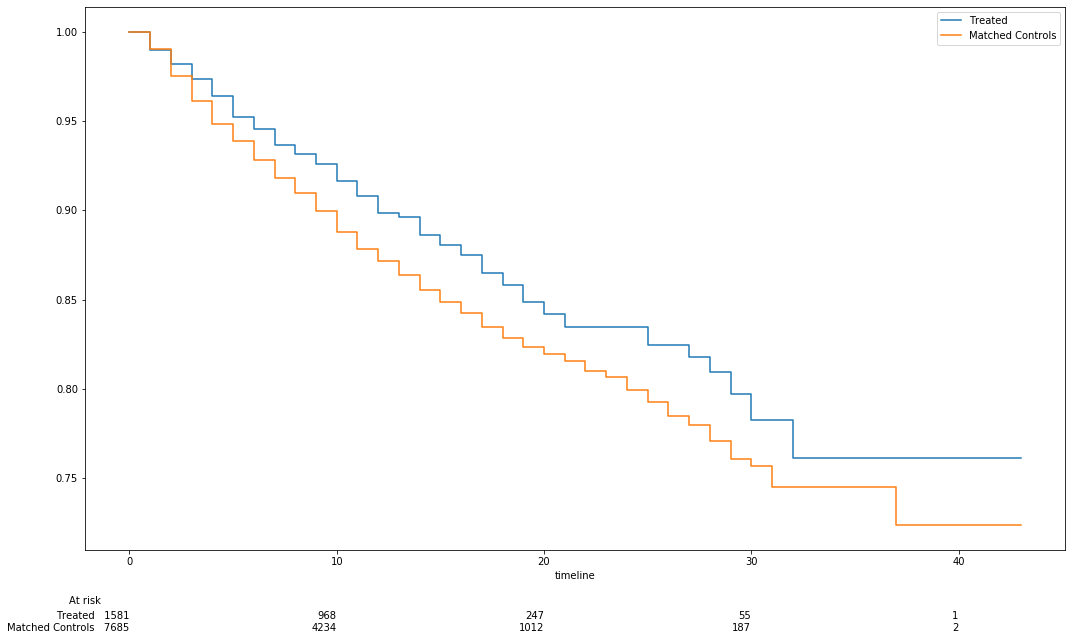

In [12]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

kmf1 = KaplanMeierFitter()

kmf1 = kmf1.fit(surv1['T'], event_observed=surv1.E, label="Treated")
ax = kmf1.plot_survival_function(ax=ax,ci_show=False)

kmf2 = KaplanMeierFitter()

kmf2 = kmf2.fit(surv3['T'], event_observed=surv3.E, label="Matched Controls")
ax = kmf2.plot_survival_function(ax=ax,ci_show=False)

add_at_risk_counts(kmf1, kmf2, ax=ax)


plt.tight_layout()


In [13]:
results = logrank_test(surv1['T'], surv3['T'], event_observed_A=surv1.E, event_observed_B=surv3.E)
results.print_summary()


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
 test_statistic    p  -log2(p)
           7.68 0.01      7.48


### Cox Proportional Hazards Model: Models the hazard function $h(t|x)$  
$h(t|x) = h_0(t)f(x)$  
where $h_0$ is the baseline hazard function depending only on time $t$  
and $f(x)$ modifies the hazard function dependent on a subject's covariates

In [14]:
from sklearn.preprocessing import MinMaxScaler

surv1['Treatment'] = 1
surv3['Treatment'] = 0

columns_to_match = ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT', 
                    'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 'CC_ISCHEMIC', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION', 'T', 'E']

surv11 = surv1.loc[:,columns_to_match]
surv31 = surv3.loc[:,columns_to_match]

columns_to_normalize = ['AGE_AT_MIDMONTH', 'ALLOW_AMT']
surv11[columns_to_normalize] = MinMaxScaler().fit_transform(surv11[columns_to_normalize].values)
surv31[columns_to_normalize] = MinMaxScaler().fit_transform(surv31[columns_to_normalize].values)


cpx1 = CoxPHFitter().fit(surv11, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)
cpx3 = CoxPHFitter().fit(surv31, duration_col = 'T', event_col = 'E', step_size = 0.1, show_progress=True)

Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -1130.01845, newton_decrement = 0.00000, seconds_since_start = 0.2Convergence completed after 17 iterations.
Iteration 17: norm_delta = 0.00000, step_size = 1.0000, ll = -7905.28211, newton_decrement = 0.00000, seconds_since_start = 0.3Convergence completed after 17 iterations.


In [15]:
fig, ax = plt.subplots(1,1, figsize = (15,9))

ax = cpx1.baseline_survival_.plot(ax = ax)
cpx3.baseline_survival_.plot(ax = ax)

ax.legend(['Treated', 'Matched Controls'])
plt.show()

### Coefficient Plot

### Treated

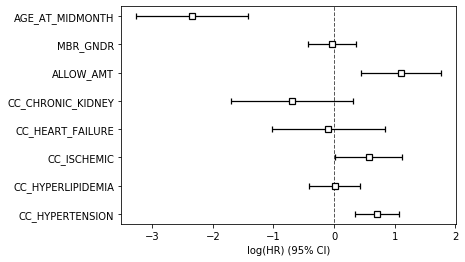

In [16]:
cols = ['AGE_AT_MIDMONTH', 'MBR_GNDR', 'ALLOW_AMT', 
                    'CC_CHRONIC_KIDNEY', 'CC_HEART_FAILURE', 'CC_ISCHEMIC', 'CC_HYPERLIPIDEMIA', 'CC_HYPERTENSION']
cpx1.plot(columns = cols)
plt.show()

In [17]:
cpx1.params_

AGE_AT_MIDMONTH     -2.343318
MBR_GNDR            -0.033425
ALLOW_AMT            1.099005
CC_CHRONIC_KIDNEY   -0.689344
CC_HEART_FAILURE    -0.093670
CC_ISCHEMIC          0.569468
CC_HYPERLIPIDEMIA    0.011511
CC_HYPERTENSION      0.707718
dtype: float64

### Matched Controls

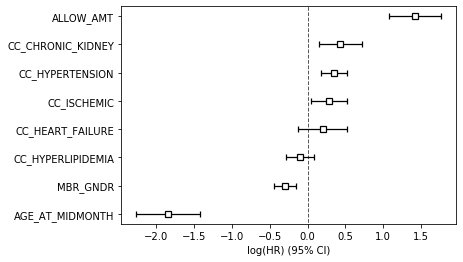

In [18]:
cpx3.plot()
plt.show()

In [19]:
cpx3.params_

AGE_AT_MIDMONTH     -1.843473
MBR_GNDR            -0.295098
ALLOW_AMT            1.415667
CC_CHRONIC_KIDNEY    0.433633
CC_HEART_FAILURE     0.200091
CC_ISCHEMIC          0.287705
CC_HYPERLIPIDEMIA   -0.097395
CC_HYPERTENSION      0.343984
dtype: float64